### Analyzing hallway task model 

In [1]:
import argparse
import os
import sys
from datetime import datetime

import numpy as np
import torch
import yaml
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 300
%matplotlib inline

import gymnasium as gym
import miniworld
from miniworld.wrappers import PyTorchObsWrapper,GreyscaleWrapper
import numpy as np


sys.path.append("../models/")
from vae_60_80 import VAE_60_80
from mdrnn import MDRNN

sys.path.append("../utils/")
from plot_functions import plot_video_comparison,plot_SPE_metrics
from torch.distributions.normal import Normal

def count_parameters(net):
    # return the number of parameters of the model
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

# we want to use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device used:", device)

from torch.utils.data import Dataset
class trajectoryDataset(Dataset):
    def __init__(self, datasetA, datasetB):
        self.datasetA = datasetA
        self.datasetB = datasetB 
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        return xA, xB
    def __len__(self):
        return len(self.datasetA)


device used: cuda


In [12]:
model_vae_path = "../../saved_models/navigation/model_vae_2023-05-05.pt"
model_mdrnn_path = "../../saved_models/navigation/model_mdrnn_rollout_changing_gain_straight_2023-05-05.pt"


wall_texture = 'stripes_big' # stripe_gradient or stripes_big

Loading the VAE model

In [13]:
# loading the VAE model


print("loading VAE model saved in", model_vae_path)

vae_params_path_recovery = model_vae_path[:-3] + ".params.yml"
with open(vae_params_path_recovery) as file:
    parameters = yaml.load(file, Loader=yaml.FullLoader)
print("using VAE parameters from " + vae_params_path_recovery)

vae_model = VAE_60_80(
    img_channels=parameters["img_channels_vae"],
    latent_dim=parameters["latent_dim_vae"],
    beta=parameters["beta_vae"],
)
vae_model.load_state_dict(torch.load(model_vae_path))
vae_model.to(device)
print("number of parameters in vae :", count_parameters(vae_model))
vae_model.load_state_dict(torch.load(model_vae_path))

loading VAE model saved in ../../saved_models/navigation/model_vae_2023-05-05.pt
using VAE parameters from ../../saved_models/navigation/model_vae_2023-05-05.params.yml
number of parameters in vae : 1963625


<All keys matched successfully>

testing the vae model

random rollout data shape : (100000, 60, 80, 1)


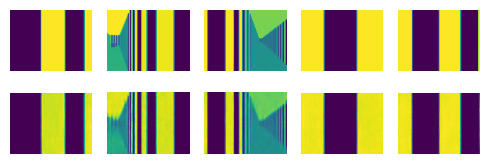

In [4]:
# testing the VAE model

import random
import matplotlib.pyplot as plt

# import random rollout data from the Task-Hallway environment
if wall_texture == "stripes_big":
    data = np.load("../../data/navigation/randomRollout.npy")
else :
    data = np.load("../../data/navigation/randomRollout_alt_texture.npy")
data = data / 255
print("random rollout data shape :",data.shape)
sample_index = np.random.randint(data.shape[0],size=5)
sample = data[sample_index]

def plot_video_comparison(video, reconstructed_video):
    nb_frame = video.shape[0]
    fig, ax = plt.subplots(2, nb_frame, figsize=(nb_frame, 2))
    for i in range(video.shape[0]):
        ax[0, i].imshow(video[i, :, :])
        ax[0, i].axis("off")
    for i in range(video.shape[0]):
        ax[1, i].imshow(reconstructed_video[i, :, :])
        ax[1, i].axis("off")
    fig.tight_layout()


imgs_tensor = torch.tensor(sample).to(device).float().unsqueeze(1).squeeze(-1)
out_tensor, mu, logsigma = vae_model(imgs_tensor)
out = out_tensor.cpu().detach().numpy()
imgs_tensor = imgs_tensor.cpu().detach().numpy()
plot_video_comparison(imgs_tensor.squeeze(1),out.squeeze(1))

In [29]:
'''
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

import ipywidgets as widgets
from ipywidgets import FloatSlider, IntSlider, interactive_output, HBox, Layout


def plot_latent(**kwargs):
    """
    Print the current widget value in short sentence
    """
    z = []
    for z_i in locals()['kwargs']:
        z.append(locals()['kwargs'][z_i])
    z = torch.tensor(z).unsqueeze(0).float().to(device)
    out = vae_model.decoder_pass(z)
    outimg = np.transpose(out[0].cpu().detach().numpy(), [1,2,0])
    ax.imshow(np.squeeze(outimg))
    ax.set_axis_off()
    fig.canvas.draw()
    
latent_dim = mu.shape[1]
latent_variables_init = {}
for i in range(latent_dim):
    latent_variables_init["z_"+str(i)] = mu[0,i].cpu().detach().item()
w = widgets.interactive(plot_latent,**latent_variables_init)
for slider in w.children:
    slider.min = -4
    slider.max = 4
    slider.orientation='vertical'
    slider.layout = Layout(width='90%')

display(HBox(w.children))
'''

'\n%matplotlib widget\nfig = plt.figure()\nax = fig.add_subplot(1, 1, 1)\n\nimport ipywidgets as widgets\nfrom ipywidgets import FloatSlider, IntSlider, interactive_output, HBox, Layout\n\n\ndef plot_latent(**kwargs):\n    """\n    Print the current widget value in short sentence\n    """\n    z = []\n    for z_i in locals()[\'kwargs\']:\n        z.append(locals()[\'kwargs\'][z_i])\n    z = torch.tensor(z).unsqueeze(0).float().to(device)\n    out = vae_model.decoder_pass(z)\n    outimg = np.transpose(out[0].cpu().detach().numpy(), [1,2,0])\n    ax.imshow(np.squeeze(outimg))\n    ax.set_axis_off()\n    fig.canvas.draw()\n    \nlatent_dim = mu.shape[1]\nlatent_variables_init = {}\nfor i in range(latent_dim):\n    latent_variables_init["z_"+str(i)] = mu[0,i].cpu().detach().item()\nw = widgets.interactive(plot_latent,**latent_variables_init)\nfor slider in w.children:\n    slider.min = -4\n    slider.max = 4\n    slider.orientation=\'vertical\'\n    slider.layout = Layout(width=\'90%\')\n\

Loading the MDRNN model

In [14]:
mdrnn_model = MDRNN(
            latent_dim=parameters["latent_dim_mdrnn"],
            action_dim=parameters["action_dim_mdrnn"],
            hidden_dim=parameters["hidden_dim_mdrnn"],
            gaussians_nb=parameters["gaussians_nb_mdrnn"],
        ).to(device)
print("number of parameters :", count_parameters(mdrnn_model))
mdrnn_model.load_state_dict(torch.load(model_mdrnn_path))

number of parameters : 24873


<All keys matched successfully>

### A trajectory through all gain changes

Creating the test environment

In [15]:
control_args = dict(
        min_section_length=50,
        max_section_length = 51,
        max_episode_steps = 100,
        facing_forward = True,
        reset_keep_same_length = True,
        wall_tex = wall_texture
    )

env = gym.make('MiniWorld-TaskHallwaySimple-v0', 
                view="agent", render_mode=None,
                **control_args)
env = GreyscaleWrapper(env)

hallway length :  50


In [16]:

nb_control_trajectories =  50
trajectories_observations =  []

glitch = False

for i_traj in tqdm(range(nb_control_trajectories)):

    if wall_texture == "stripes_big":
        gains =  [1,0.5,1,1.5,0.5,1.5,1]
    else :
        gains =  [2,1,2,3,1,3,2] #  [1,0.3,1,3,0.3,3,1] #  [2,1,2,4,1,4,2] # 
    gain_change_steps = [0,15,30,45,60,75,90]

    observations = []
    observation, info = env.reset()

    for i_step in range(control_args['max_episode_steps']-1):

        if (len(gain_change_steps) > 0) and (i_step == gain_change_steps[0]) :

            env.change_gain(random=False,gain=gains[0],glitch=glitch,glitch_phase = np.random.uniform(-0.8,0.8))
            gain_change_steps.pop(0)
            gains.pop(0)

        action = 2 # env.action_space.sample()  # agent policy that uses the observation and info
        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            print("oups")
            observation, info = env.reset()

        observations.append(observation)

    observations = np.stack(observations).squeeze(-1)

    trajectories_observations.append(observations)
    
env.close()

100%|██████████| 50/50 [00:09<00:00,  5.37it/s]


In [17]:
# normalize pixel values of the observations
trajectories_observations = np.stack(trajectories_observations) / 255
trajectories_observations = np.array(trajectories_observations,dtype=np.float32)

# the action is always to go straight forward
trajectories_actions = np.zeros((nb_control_trajectories,control_args['max_episode_steps'],3))
trajectories_actions[:,:,2] = 1
trajectories_actions = np.array(trajectories_actions,dtype=np.int32)

print(trajectories_observations.shape)
print(trajectories_actions.shape)

(50, 99, 60, 80)
(50, 100, 3)


In [18]:
def gmm_loss(batch,mus,sigmas,logpi):

    batch = batch.unsqueeze(-2)
    normal_dist = Normal(mus, sigmas)
    g_log_probs = normal_dist.log_prob(batch)
    g_log_probs = logpi + torch.sum(g_log_probs, dim=-1)
    max_log_probs = torch.max(g_log_probs, dim=-1, keepdim=True)[0]
    g_log_probs = g_log_probs - max_log_probs

    g_probs = torch.exp(g_log_probs)
    probs = torch.sum(g_probs, dim=-1)

    log_prob = max_log_probs.squeeze() + torch.log(probs)

    return - log_prob


def run_model_prediction(video,act):

    loss = []
    video = np.transpose(video,(1,0,2,3))
    seq_len,batch_size,_,_ = video.shape
    video_tensor = torch.reshape(torch.tensor(video).float(),(-1,1,60,80)).float().to(device)
    reconstructed_video,latent_video, latent_video_variance  = vae_model(video_tensor)
    latent_dim = latent_video.shape[-1]
    latent_video = torch.reshape(latent_video,(seq_len,batch_size,latent_dim))
    latent_video_variance = torch.reshape(latent_video_variance,(seq_len,batch_size,latent_dim))
    reconstructed_video = torch.reshape(reconstructed_video,(seq_len,batch_size,60,80))

    if mdrnn_model.memory == 'rnn':
        hidden = torch.zeros(batch_size, mdrnn_model.hidden_dim).to(device)
    else :
        hidden = (torch.zeros(1,batch_size, mdrnn_model.hidden_dim).to(device),
                        torch.zeros(1,batch_size, mdrnn_model.hidden_dim).to(device))

    actions = torch.transpose(torch.tensor(act),0,1).to(device)
    
    mean_pred = []
    sig_pred = []
    for t in range(seq_len):

        latent = latent_video[t,:,:]
        action = actions[t,:,:]

        if mdrnn_model.memory == 'rnn':

            mus, sigmas, logpi, next_hidden = mdrnn_model(action,latent,hidden)
            hidden = next_hidden[1].squeeze(0)
        else :
            mus, sigmas, logpi, next_hidden = mdrnn_model(action,latent,hidden)
            hidden = next_hidden

        if t < seq_len-1 :
            loss.append( gmm_loss(latent_video[t+1,:,:],mus,sigmas,logpi).cpu().detach().numpy() )


        mean_pred.append(mus[:,0,:].cpu().detach().numpy())
        sig_pred.append(sigmas[:,0,:].cpu().detach().numpy())

    loss = np.stack(loss).T
    predicted_latent = torch.tensor(mean_pred).to(device)
    predicted_latent = torch.reshape(predicted_latent,(-1,20))
    predicted_video = vae_model.decoder(predicted_latent)
    predicted_video = torch.reshape(predicted_video,(seq_len,batch_size,60,80))
    
    mean_pred = np.array(mean_pred).transpose(1,0,2)
    sig_pred = np.array(sig_pred).transpose(1,0,2)
    latent_video = latent_video.cpu().detach().numpy().transpose(1,0,2)
    latent_video_variance = np.exp(latent_video_variance.cpu().detach().numpy()).transpose(1,0,2)
    reconstructed_video = reconstructed_video.cpu().detach().numpy().transpose(1,0,2,3)
    predicted_video = predicted_video.cpu().detach().numpy().transpose(1,0,2,3)
    
    return reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred,predicted_video,loss

In [19]:
reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred,predicted_video,loss = run_model_prediction(trajectories_observations,trajectories_actions)

5.5916607e-05 2.0121489


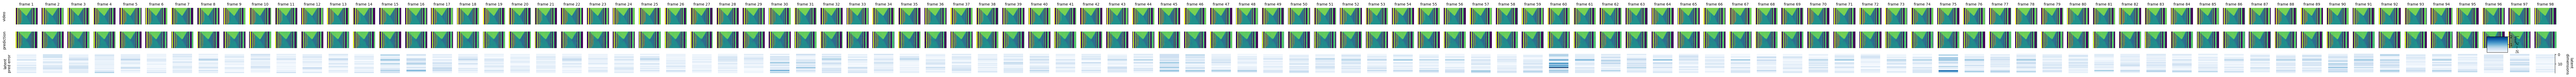

In [20]:


def plot_video_comparison(video, reconstructed_video,latent_var=False,latent_pred_error=None):

    vmin = latent_pred_error.min()
    vmax = latent_pred_error.max()
    print(vmin,vmax)
    nb_frame = video.shape[0]
    if latent_var :
        fig, ax = plt.subplots(3, nb_frame, figsize=(nb_frame, 3))
    else :
        fig, ax = plt.subplots(2, nb_frame, figsize=(nb_frame, 2))
    for i in range(video.shape[0]):
        ax[0, i].imshow(video[i, :, :])
        ax[0, i].axis("off")
        ax[0, i].annotate('frame '+str(i+1),
            xy=(0.5, 1.1), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='bottom')
    for i in range(video.shape[0]):
        ax[1, i].imshow(reconstructed_video[i, :, :])
        ax[1, i].axis("off")
    
    for i in range(video.shape[0]):
        im = ax[2, i].imshow(latent_pred_error[i:i+1,:].T,aspect=0.05,vmin=vmin,vmax=vmax,cmap='Blues')
        ax[2, i].axis("off")

    ax[0, 0].annotate('video',
            xy=(-0.5, 0.5), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',rotation='vertical')
    ax[1, 0].annotate('prediction',
            xy=(-0.5, 0.5), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',rotation='vertical')
    ax[2, 0].annotate('latent\npred error',
            xy=(-0.5, 0.5), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',rotation='vertical')
    ax[2, -1].annotate('latent \n dimensions',
            xy=(1.75, 0.5), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',rotation=270)
    ax[2, -1].axis("on")
    ax[2, -1].yaxis.tick_right()
    ax[2, -1].xaxis.set_visible(False)
    ax[2, -1].spines[['left','bottom','top']].set_visible(False)

    fig.tight_layout()

    cax = fig.add_axes([0.965, .34, 0.008, 0.2])
    fig.colorbar(im, orientation="vertical", pad=0.2,cax=cax,label=r'$|z_i - z_i^{pred}|$')
    plt.show()

sample = 1
plot_video_comparison(trajectories_observations[sample][1:],reconstructed_video[sample][:-1],latent_var=True,latent_pred_error= np.abs(mean_pred[sample][:-1] - latent_video[sample][1:]))

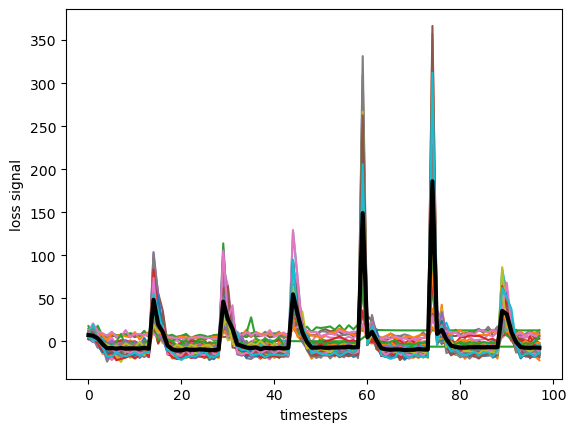

In [21]:
plt.figure()
plt.plot(loss.T)
plt.plot(np.mean(loss,axis=0),color='k',lw=3)
plt.xlabel('timesteps')
plt.ylabel('loss signal')
plt.show()

(50, 98, 20)


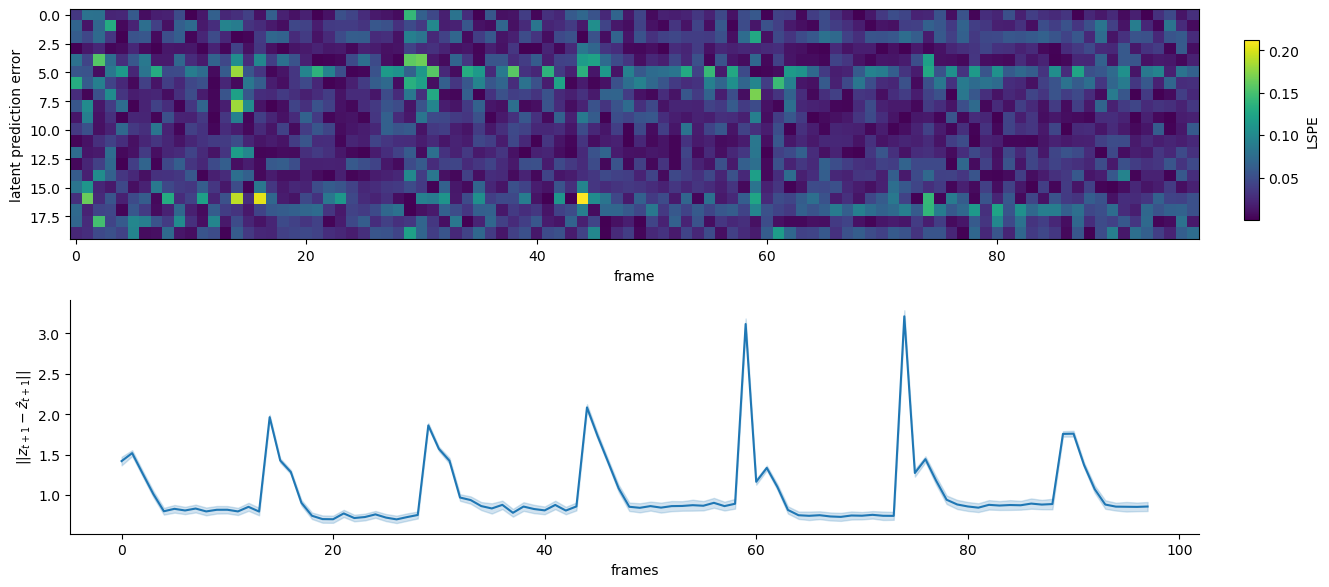

In [24]:
import seaborn as sns

def plot_SPE_metrics(latent_video, latent_video_variance, mean_pred, sig_pred):
    z = np.mean(latent_video, axis=0).T
    z_pred = np.mean(mean_pred, axis=0).T

    # first measure of SPE : norm between z_t and mean of P(z_t|h_t-1)
    z_error = np.abs(z_pred[:, :-1] - z[:, 1:])
    
    # z_error_norm = np.linalg.norm(z_error, axis=0)

    array = mean_pred[:,:-1,:] -  latent_video[:,1:,:]
    print(array.shape)
    z_error_norm = np.mean( np.linalg.norm(array,axis=-1) ,axis=0)

    f = plt.figure(figsize=(15,6))

    plt.subplot(211)
    im = plt.imshow(z_error)

    plt.xlabel("frame")
    plt.ylabel("latent prediction error")

    ax = plt.subplot(212)
    
    sns.lineplot(x =  np.tile(np.arange(98),np.linalg.norm(array,axis=-1).flatten().shape[0] // 98), 
                 y = np.linalg.norm(array,axis=-1).flatten() ,color = 'tab:blue',ax=ax,errorbar='se')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel('frames')
    ax.set_ylabel(r'$||z_{t+1} - ẑ_{t+1}||$')

    f.tight_layout()

    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.83, 0.62, 0.01, 0.3])
    f.colorbar(im, cax=cbar_ax,label='LSPE')

    plt.show()


plot_SPE_metrics(latent_video, latent_video_variance, mean_pred, sig_pred)

### Effect of relative gain change on SPE

In [100]:
# split by gain change amplitude

nb_steps = 50
control_args = dict(
        min_section_length=50,
        max_section_length = 51,
        max_episode_steps = nb_steps+2,
        facing_forward = True,
        reset_keep_same_length = True,
        wall_tex = wall_texture
    )

env = gym.make('MiniWorld-TaskHallwaySimple-v0', 
                view="agent", render_mode=None,
                **control_args)
env = GreyscaleWrapper(env)

nb_control_trajectories = 10

if wall_texture == 'stripes_big':
    gains_test = [0.5,1,1.5] 
else :
    gains_test = [0.3,1,3] 

losses = np.zeros((3,3,nb_control_trajectories,nb_steps))
SPE_norms = np.zeros((3,3,nb_control_trajectories,nb_steps))

traj_steps = np.random.randint(15,35,size=nb_control_trajectories)

loss_0 = []
loss_m1 = []
loss_m2 = []
loss_1 = []
loss_2 = []

SPE_0 = []
SPE_m1 = []
SPE_m2 = []
SPE_1 = []
SPE_2 = []

random_change_step = True
glitch = True

for i,gain_pre in enumerate(gains_test) :
    for j,gain_post in enumerate(gains_test):
        print(gain_pre,"->",gain_post)
        trajectories_observations = []

        for i_traj in range(nb_control_trajectories):
            
            gains = [gain_pre,gain_post]
            if random_change_step :
                gain_change_steps = [traj_steps[i_traj]]
            else :
                gain_change_steps = [15]
            
            observations = []
            observation, info = env.reset()
            for i_step in range(control_args['max_episode_steps']-1):

                if i_step == 0:
                    env.change_gain(random=False,gain=gains[0],glitch=False)
                if (len(gain_change_steps) > 0) and (i_step == gain_change_steps[0]) :
                    env.change_gain(random=False,gain=gains[1],glitch=glitch,glitch_phase=np.random.uniform(-0.2,0.2))
                    gain_change_steps.pop(0)
                    gains.pop(0)

                action = 2 # env.action_space.sample()  # agent policy that uses the observation and info
                observation, reward, terminated, truncated, info = env.step(action)
                if terminated or truncated:
                    print("oups")
                    observation, info = env.reset()
                observations.append(observation)

            observations = np.stack(observations).squeeze(-1)
            actions = np.ones(control_args['max_episode_steps'])*2

            trajectories_observations.append(observations)
            

        trajectories_observations = np.stack(trajectories_observations) / 255
        trajectories_actions = np.zeros((nb_control_trajectories,control_args['max_episode_steps'],3))
        trajectories_actions[:,:,2] = 1
        trajectories_actions = np.array(trajectories_actions,dtype=np.int32)
        trajectories_observations = np.array(trajectories_observations,dtype=np.float32)

        reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred,predicted_video,loss = run_model_prediction(trajectories_observations,trajectories_actions)
        losses[i,j] = loss

        z = latent_video
        z_pred = mean_pred

        # first measure of SPE : norm between z_t and mean of P(z_t|h_t-1)
        z_error = np.abs(z_pred[:,:-1,:] - z[:,1:,:])
        spe_norm = np.linalg.norm(z_error,axis=-1)

        # z_error_norm = np.linalg.norm(z_error, axis=0)
        SPE_norms[i,j] = spe_norm
        
        if i-j == 0:
            loss_0.append(loss)
            SPE_0.append(spe_norm)
        elif i-j == -1:
            loss_m1.append(loss)
            SPE_m1.append(spe_norm)
        elif i-j == -2:
            loss_m2.append(loss)
            SPE_m2.append(spe_norm)
        elif i-j == 1:
            loss_1.append(loss)
            SPE_1.append(spe_norm)
        else :
            loss_2.append(loss)
            SPE_2.append(spe_norm)

env.close()

hallway length :  50
0.5 -> 0.5
0.5 -> 1
0.5 -> 1.5
1 -> 0.5
1 -> 1
1 -> 1.5
1.5 -> 0.5
1.5 -> 1
1.5 -> 1.5


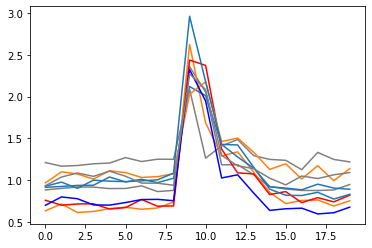

In [101]:
plt.figure()
color_dict = { "-2": 'blue',
               "-1": 'tab:blue',
               "0": 'grey',
               "1": 'tab:orange',
               "2":'red' }
relative_gain_change_color = ['blue','tab:blue','grey','tab:orange','red']

for i in range(3):
    for j in range(3):
        diff = str(j-i)
        aligned_loss = []
        for i_traj in range(nb_control_trajectories):
            aligned_loss.append( SPE_norms[i,j,i_traj,traj_steps[i_traj]-10:traj_steps[i_traj]+10] )
        plt.plot( np.mean(aligned_loss,axis=0),color = color_dict[diff],label=diff)

plt.show()

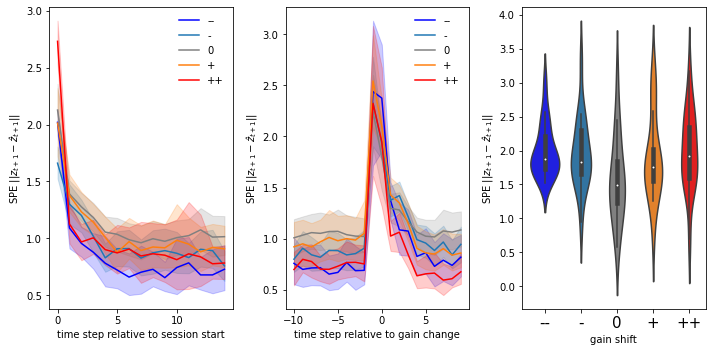

In [102]:
import seaborn as sns

plt.figure(figsize=(10,5))

relative_gain_change_losses =  [SPE_m2,SPE_m1,SPE_0,SPE_1,SPE_2] #   

relative_gain_change_label = ['--','-','0','+','++']
relative_gain_change_color = ['blue','tab:blue','grey','tab:orange','red']

plt.subplot(131)
for i,loss in enumerate(relative_gain_change_losses):
    aligned_loss = []
    for l in range(len(loss)):
        for i_traj in range(nb_control_trajectories):
            aligned_loss.append( loss[l][i_traj,0:15])
    # plt.plot(np.arange(0,15),np.mean(aligned_loss,axis=0),color = relative_gain_change_color[i],label=relative_gain_change_label[i])
    sns.lineplot(x = np.tile(np.arange(0,15), np.array(aligned_loss).flatten().shape[0] // 15), y = np.array(aligned_loss).flatten(),color = relative_gain_change_color[i],label=relative_gain_change_label[i])

plt.xlabel('time step relative to session start')
plt.ylabel(r"SPE $||z_{t+1} - ẑ_{t+1}||$")
plt.legend(frameon=False)


plt.subplot(132)
relative_gain_change_peak_vals = []
for i,loss in enumerate(relative_gain_change_losses):
    aligned_loss = []
    for l in range(len(loss)):
        for i_traj in range(nb_control_trajectories):
            aligned_loss.append( loss[l][i_traj,traj_steps[i_traj]-10:traj_steps[i_traj]+10])
    peak_val = np.mean(np.array(aligned_loss)[:,9:12],axis=1)
    relative_gain_change_peak_vals.extend(peak_val)
    sns.lineplot(x = np.tile(np.arange(-10,10), np.array(aligned_loss).flatten().shape[0] // 20), y = np.array(aligned_loss).flatten(),color = relative_gain_change_color[i],label=relative_gain_change_label[i])

plt.xlabel('time step relative to gain change')
plt.ylabel(r"SPE $||z_{t+1} - ẑ_{t+1}||$")
plt.legend(frameon=False)

plt.subplot(133)

sns.violinplot(x=list(np.repeat(range(5),len(relative_gain_change_peak_vals) //5)),y=relative_gain_change_peak_vals,palette = relative_gain_change_color)

plt.xticks(ticks=[0,1,2,3,4],labels=['--','-','0','+','++'],fontsize=15)
plt.xlabel('gain shift')
plt.ylabel(r"SPE $||z_{t+1} - ẑ_{t+1}||$")
plt.plot()

plt.tight_layout()

### Effect of glitch on SPE

In [94]:
# split by gain change amplitude

nb_steps = 50


env = gym.make('MiniWorld-TaskHallwaySimple-v0', 
                view="agent", render_mode=None,
                **control_args)
env = GreyscaleWrapper(env)

nb_control_trajectories = 10

glitch_phases = [-0.8,-0.4,0,0.4,0.8]

if wall_texture == 'stripes_big' :
    gains_test = [0.5,1,1.5]
else :
    gains_test = [1,2,3]

losses = np.zeros((len(glitch_phases),nb_control_trajectories,nb_steps))
SPE_norms = np.zeros((len(glitch_phases),nb_control_trajectories,nb_steps))

traj_steps = np.random.randint(15,35,size=nb_control_trajectories)

random_change_step = True


for i,glitch_phase in enumerate(glitch_phases) :
    print(glitch_phase)

    trajectories_observations = []

    for i_traj in range(nb_control_trajectories):
        
        gains = [gain_pre,gain_post]
        if random_change_step :
            gain_change_steps = [traj_steps[i_traj]]
        else :
            gain_change_steps = [15]

        observations = []
        observation, info = env.reset()

        for i_step in range(control_args['max_episode_steps']-1):

            if i_step == 0 :
                env.change_gain(random=True,gain=gains_test,glitch=False)

            if (len(gain_change_steps) > 0) and (i_step == gain_change_steps[0]):
                env.change_gain(random=True,gain=gains_test,glitch=True,glitch_phase=glitch_phase)
                gain_change_steps.pop(0)
                gains.pop(0)

            action = 2 # env.action_space.sample()  # agent policy that uses the observation and info
            observation, reward, terminated, truncated, info = env.step(action)
            if terminated or truncated:
                print("oups")
                observation, info = env.reset()
            observations.append(observation)

        observations = np.stack(observations).squeeze(-1)
        actions = np.ones(control_args['max_episode_steps'])*2

        trajectories_observations.append(observations)
        
    trajectories_observations = np.stack(trajectories_observations) / 255
    trajectories_actions = np.zeros((nb_control_trajectories,control_args['max_episode_steps'],3))
    trajectories_actions[:,:,2] = 1
    trajectories_actions = np.array(trajectories_actions,dtype=np.int32)
    trajectories_observations = np.array(trajectories_observations,dtype=np.float32)

    reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred,predicted_video,loss = run_model_prediction(trajectories_observations,trajectories_actions)
    losses[i] = loss

    z = latent_video
    z_pred = mean_pred

    # first measure of SPE : norm between z_t and mean of P(z_t|h_t-1)
    z_error = np.abs(z_pred[:,:-1,:] - z[:,1:,:])
    spe_norm = np.linalg.norm(z_error,axis=-1)

    # z_error_norm = np.linalg.norm(z_error, axis=0)
    SPE_norms[i] = spe_norm

env.close()

hallway length :  50
-0.8
-0.4
0
0.4
0.8


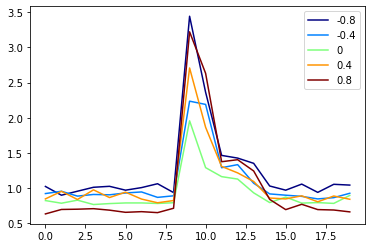

In [95]:
plt.figure()

colors = plt.cm.jet(np.linspace(0,1,len(glitch_phases)))

for i,glitch_phase in enumerate(glitch_phases):
        aligned_loss = []
        for i_traj in range(nb_control_trajectories):
            aligned_loss.append( SPE_norms[i,i_traj,traj_steps[i_traj]-10:traj_steps[i_traj]+10] )
        plt.plot( np.mean(aligned_loss,axis=0),color=colors[i],label=glitch_phase)
plt.legend()
plt.show()

-0.8
-0.4
0
0.4
0.8


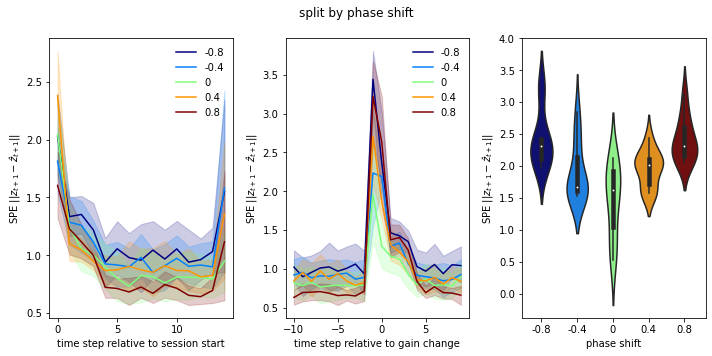

In [96]:
import seaborn as sns

f = plt.figure(figsize=(10,5))


plt.subplot(131)
for i,glitch_phase in enumerate(glitch_phases):
    aligned_loss = []
    for i_traj in range(nb_control_trajectories):
        aligned_loss.append( SPE_norms[i,i_traj,0:15])
    sns.lineplot(x = np.tile(np.arange(0,15), np.array(aligned_loss).flatten().shape[0] // 15), y = np.array(aligned_loss).flatten(),color = colors[i],label=glitch_phase)

plt.xlabel('time step relative to session start')
plt.ylabel(r"SPE $||z_{t+1} - ẑ_{t+1}||$")
plt.legend(frameon=False)



plt.subplot(132)
relative_gain_change_peak_vals = []

for i,glitch_phase in enumerate(glitch_phases):
    print(glitch_phase)
    aligned_loss = []
    for i_traj in range(nb_control_trajectories):
        aligned_loss.append( SPE_norms[i,i_traj,traj_steps[i_traj]-10:traj_steps[i_traj]+10])
    peak_val = np.mean(np.array(aligned_loss)[:,9:12],axis=1)
    relative_gain_change_peak_vals.extend(peak_val)
    sns.lineplot(x = np.tile(np.arange(-10,10), np.array(aligned_loss).flatten().shape[0] // 20), y = np.array(aligned_loss).flatten(),color = colors[i],label=glitch_phase)

plt.xlabel('time step relative to gain change')
plt.ylabel(r"SPE $||z_{t+1} - ẑ_{t+1}||$")
plt.legend(frameon=False)

plt.subplot(133)

sns.violinplot(x=list(np.repeat(range(len(glitch_phases)),len(relative_gain_change_peak_vals) //len(glitch_phases))),y=relative_gain_change_peak_vals,palette = colors)

plt.xticks(ticks=np.arange(len(glitch_phases)),labels=glitch_phases)
plt.xlabel('phase shift')
plt.ylabel(r"SPE $||z_{t+1} - ẑ_{t+1}||$")
plt.plot()

f.suptitle('split by phase shift')

plt.tight_layout()